In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LinearRegression
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"
# Start a SparkSession
import findspark
findspark.init()
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("breastcancer").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://breastcancer-mackalys.s3.amazonaws.com/data.csv"
spark.sparkContext.addFile(url)
breast_cancer_df = spark.read.csv(SparkFiles.get("data.csv"), sep=",", header=True, inferSchema=True)
# Print our DataFrame
breast_cancer_df.show()

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [787 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea

In [2]:
#Convert PySpark Dataframe to Pandas DataFrame
Breast_cancer_df = breast_cancer_df.toPandas()
#Breast_cancer_df.head()

In [3]:
Breast_cancer_df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [4]:
# Drop any rows with null values
Breast_cancer_df = Breast_cancer_df.dropna()

In [5]:
# Change Benign to 1 and  Malignant to 2
key_rev_diag = {'B' : 1, 'M' : 2}
Breast_cancer_df = Breast_cancer_df.replace(key_rev_diag)
Breast_cancer_df

id  diagnosis  radius_mean  texture_mean  perimeter_mean  \
0      842302          2        17.99         10.38          122.80   
1      842517          2        20.57         17.77          132.90   
2    84300903          2        19.69         21.25          130.00   
3    84348301          2        11.42         20.38           77.58   
4    84358402          2        20.29         14.34          135.10   
..        ...        ...          ...           ...             ...   
564    926424          2        21.56         22.39          142.00   
565    926682          2        20.13         28.25          131.20   
566    926954          2        16.60         28.08          108.30   
567    927241          2        20.60         29.33          140.10   
568     92751          1         7.76         24.54           47.92   

     area_mean  smoothness_mean  compactness_mean  concavity_mean  \
0       1001.0          0.11840           0.27760         0.30010   
1       1326.0          0.08474           0.07864         0.08690   
2       1203.0          0.10960           0.15990         0.19740   
3        386.1          0.14250           0.28390         0.24140   
4       1297.0          0.10030           0.13280         0.19800   
..         ...              ...               ...             ...   
564     1479.0          0.11100           0.11590         0.24390   
565     1261.0          0.09780           0.10340         0.14400   
566      858.1          0.08455           0.10230         0.09251   
567     1265.0          0.11780           0.27700         0.35140   
568      181.0          0.05263           0.04362         0.00000   

     concave_points_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0                0.14710  ...        25.380          17.33           184.60   
1                0.07017  ...        24.990          23.41           158.80   
2                0.12790  ...        23.570          25.53           152.50   
3                0.10520  ...        14.910          26.50            98.87   
4                0.10430  ...        22.540          16.67           152.20   
..                   ...  ...           ...            ...              ...   
564              0.13890  ...        25.450          26.40           166.10   
565              0.09791  ...        23.690          38.25           155.00   
566              0.05302  ...        18.980          34.12           126.70   
567              0.15200  ...        25.740          39.42           184.60   
568              0.00000  ...         9.456          30.37            59.16   

     area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0        2019.0           0.16220            0.66560           0.7119   
1        1956.0           0.12380            0.18660           0.2416   
2        1709.0           0.14440            0.42450           0.4504   
3         567.7           0.20980            0.86630           0.6869   
4        1575.0           0.13740            0.20500           0.4000   
..          ...               ...                ...              ...   
564      2027.0           0.14100            0.21130           0.4107   
565      1731.0           0.11660            0.19220           0.3215   
566      1124.0           0.11390            0.30940           0.3403   
567      1821.0           0.16500            0.86810           0.9387   
568       268.6           0.08996            0.06444           0.0000   

     concave_points_worst  symmetry_worst  fractal_dimension_worst  
0                  0.2654          0.4601                  0.11890  
1                  0.1860          0.2750                  0.08902  
2                  0.2430          0.3613                  0.08758  
3                  0.2575          0.6638                  0.17300  
4                  0.1625          0.2364                  0.07678  
..                    ...             ...                      ...  
564                0

In [6]:
#find count of malignant and benign diagnosis
Breast_cancer_df["diagnosis"].value_counts()

1    357
2    212
Name: diagnosis, dtype: int64

In [7]:
# Preping 2nd Df for Second model; Please see our notes at the end for explanation.
# Droping all cellular dimensional measurements
Breast_cancer2_df = Breast_cancer_df.drop(["perimeter_mean", "radius_mean", "area_mean","perimeter_se", "radius_se", "area_se", "perimeter_worst", "radius_worst", "area_worst"], axis=1)

**Split the Data into Training and Testing**

In [ ]:
# Create our Feature
X = Breast_cancer_df.drop(["diagnosis","id"], axis=1)
X = pd.get_dummies(X)

# Create our Target
y = Breast_cancer_df["diagnosis"]

In [ ]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
print(f'Train set lenght: {X_train.count()} records')
print(f'Test set lenght: {X_test.count()} records')

Train set lenght: radius_mean                381
texture_mean               381
perimeter_mean             381
area_mean                  381
smoothness_mean            381
compactness_mean           381
concavity_mean             381
concave_points_mean        381
symmetry_mean              381
fractal_dimension_mean     381
radius_se                  381
texture_se                 381
perimeter_se               381
area_se                    381
smoothness_se              381
compactness_se             381
concavity_se               381
concave points_se          381
symmetry_se                381
fractal_dimension_se       381
radius_worst               381
texture_worst              381
perimeter_worst            381
area_worst                 381
smoothness_worst           381
compactness_worst          381
concavity_worst            381
concave_points_worst       381
symmetry_worst             381
fractal_dimension_worst    381
dtype: int64 records
Test set lenght: radius_mean   

In [ ]:
# Check the Feature values
X.describe()

radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  fractal_dimension_mean  ...  radius_worst  \
count     569.000000              569.000000  ...    569.000000   
mean        0.181162                0.062798  ...     16.269190   
std         0.027414                0.007060  ...      4.833242   
min         0.106000                0.049960  ...      7.930000   
25%         0.161900                0.057700  ...     13.010000   
50%         0.179200                0.061540  ...     14.970000   
75%         0.195700                0.066120  ...     18.790000   
max         0.304000                0.097440  ...     36.040000   

       texture_worst  perimeter_worst   area_worst  smoothness_worst  \
count     569.000000       569.000000   569.000000        569.000000   
mean       25.677223       107.261213   880.583128          0.132369   
std         6.146258        33.602542   569.356993          0.022832   
min        12.020000        50.410000   185.200000          0.071170   
25%        21.080000        84.110000   515.300000          0.116600   
50%        25.410000        97.660000   686.500000          0.131300   
75%        29.720000       125.400000  1084.000000          0.146000   
max        49.540000       251.200000  4254.000000          0.222600   

       compactness_worst  concavity_worst  concave_points_worst  \
count         569.000000       569.000000            569.000000   
mean            0.254265         0.272188              0.114606   
std             0.157336         0.208624              0.065732   
min             0.027290         0.000000              0.000000   
25%             0.147200         0.114500              0.064930   
50%             0.211900         0.226700              0.099930   
75%             0.339100         0.382900              0.161400   
max             1.058000         1.252000              0.291000   

       symmetry_worst  fractal_dimension_worst  
count      569.000000               569.000000  
mean         0.290076                 0.083946  
std          0.061867                 0.018061  
min          0.156500                 0.055040  
25%          0.250400                 0.071460  
50%          0.282200                 0.080040  
75%          0.317900                 0.092080  
max          0.663800                 0.207500  

[8 rows x 30 columns]

In [ ]:
# Check the balance of the Target values
y.value_counts()

1    357
2    212
Name: diagnosis, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

len(X_train), len(X_test)

(426, 143)

**Scale the Data**

In [ ]:
# Scale the Data
scaled_data = StandardScaler()
X_train = scaled_data.fit_transform(X_train)
X_test = scaled_data.transform(X_test)

**Balance the Data**

In [ ]:
# Balance the data since the y values are imblanced
over_samp =  RandomOverSampler(random_state=42)
X_train_res, y_train_res = over_samp.fit_resample(X, y)
X_train_res.shape, y_train_res.shape

((714, 30), (714,))

**Linear Regression Model with all Features**

In [ ]:
# Build Linear Regression Model with all the features
# Create and fit the model
model = LinearRegression()
model.fit(X_test, y_test)

LinearRegression()

In [ ]:
LinearRegressionScore = model.score(X_test, y_test)
print("Accuracy Score for Linear Regression model including all features:",LinearRegressionScore*100,"%")

Accuracy Score for Linear Regression model including all features: 84.27219845687677 %


In [ ]:
#logistic regression import
from sklearn.linear_model import LogisticRegression

#logistic regression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [ ]:
#fit training data
classifier.fit(X_train, y_train)


LogisticRegression(max_iter=200, random_state=1)

In [ ]:
#predict values
y_pred = classifier.predict(X_test)

#print results
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(20)

Prediction  Actual
0            1       1
1            2       2
2            2       2
3            1       1
4            1       1
5            2       2
6            2       2
7            2       2
8            1       1
9            1       1
10           1       1
11           2       2
12           1       1
13           2       2
14           1       1
15           2       2
16           1       1
17           1       1
18           1       1
19           2       2

In [ ]:
#accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9790209790209791


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Classification Report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(cm_df)

Classification Report
              precision    recall  f1-score   support

           1       0.99      0.98      0.98        89
           2       0.96      0.98      0.97        54

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143

Confusion Matrix
          Predicted 0  Predicted 1
Actual 0           87            2
Actual 1            1           53


<function matplotlib.pyplot.show>

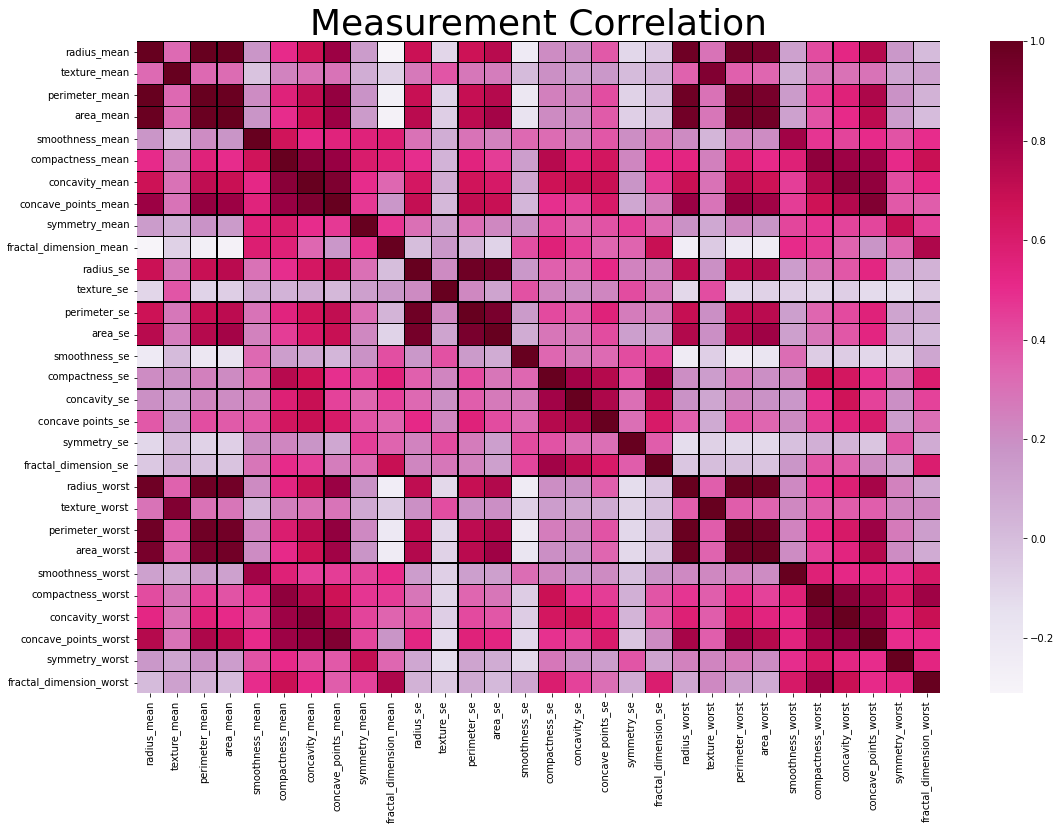

In [13]:
#import seaborn and matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt

#drop non measurement columns
x_plot = Breast_cancer_df.drop(['id','diagnosis'],axis=1)

#.corr correlation between columns
x_corr = x_plot.corr()

#heatmap seaborn
fig, ax = plt.subplots(figsize=(18,12))

corr_plot = sns.heatmap(x_corr, cmap="PuRd", linewidths=.15, linecolor= 'black')
sns.set(font_scale = 3)

ax.set_title('Measurement Correlation')

#display
plt.show

In [ ]:

print("These are the features we identified to have strong positive correlations:")
print(" ")
print("Perimeter mean vs Radius mean")
print("Perimeter mean vs Radius worst")
print("Perimeter mean vs Area mean")
print("Perimeter mean vs Area worst")
print("Radius mean vs Area worst")
print("Radius mean vs Area worst")
print("Area mean vs Radius mean")


These are the features we identified to have strong positive correlations:
 
Perimeter mean vs Radius mean
Perimeter mean vs Radius worst
Perimeter mean vs Area mean
Perimeter mean vs Area worst
Radius mean vs Area worst
Radius mean vs Area worst
Area mean vs Radius mean


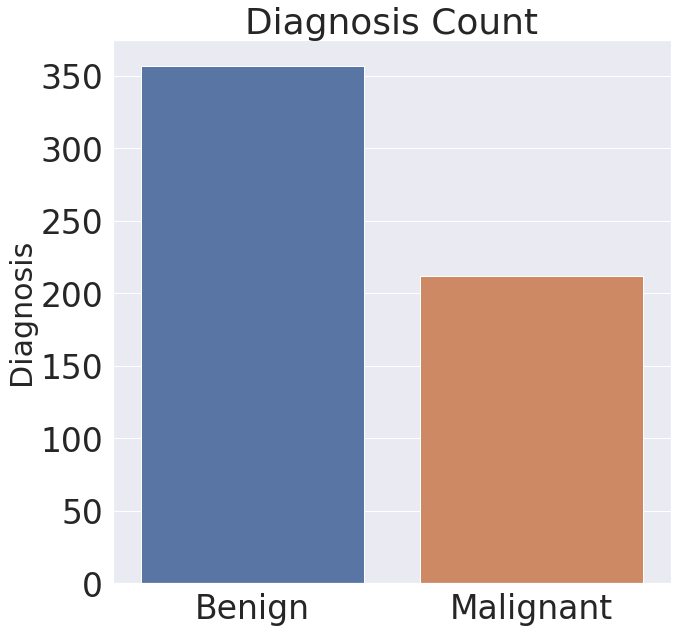

In [ ]:
#bar chart diagnosis count malignant and benign
fig, ax = plt.subplots(figsize=(10,10))

axes = sns.barplot(x=Breast_cancer_df.diagnosis.value_counts().index, y=Breast_cancer_df.diagnosis.value_counts())

axes.set_title('Diagnosis Count')
axes.set_xticklabels(['Benign','Malignant'])
axes.set_ylabel("Diagnosis", fontsize = 30)


plt.show() 


# Examples with Strong Correlations

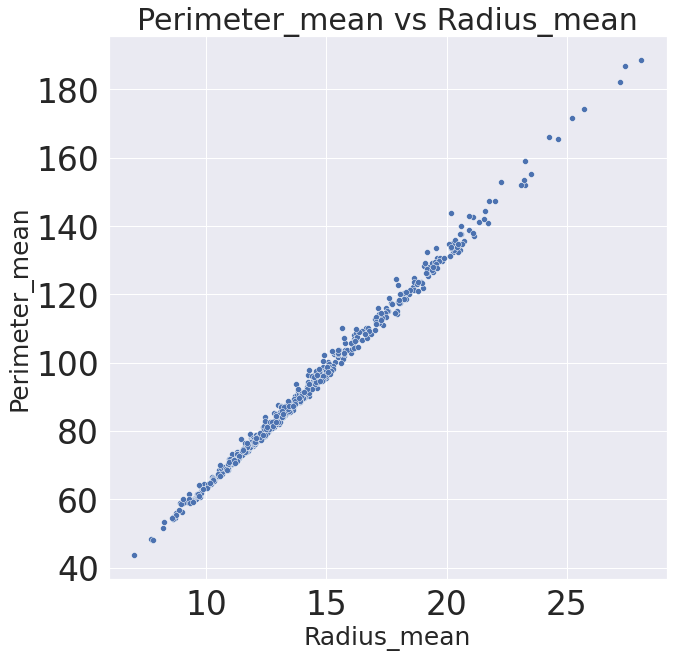

In [ ]:
# Perimeter_mean vs Radius_mean
#scatter plot 
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot Perimeter_mean vs Radius_mean
axes = sns.scatterplot(data = Breast_cancer_df, x = "radius_mean", y= "perimeter_mean")

axes.set_title('Perimeter_mean vs Radius_mean', fontsize = 30)
axes.set_xlabel("Radius_mean", fontsize = 25)
axes.set_ylabel("Perimeter_mean", fontsize = 25)



plt.show() 

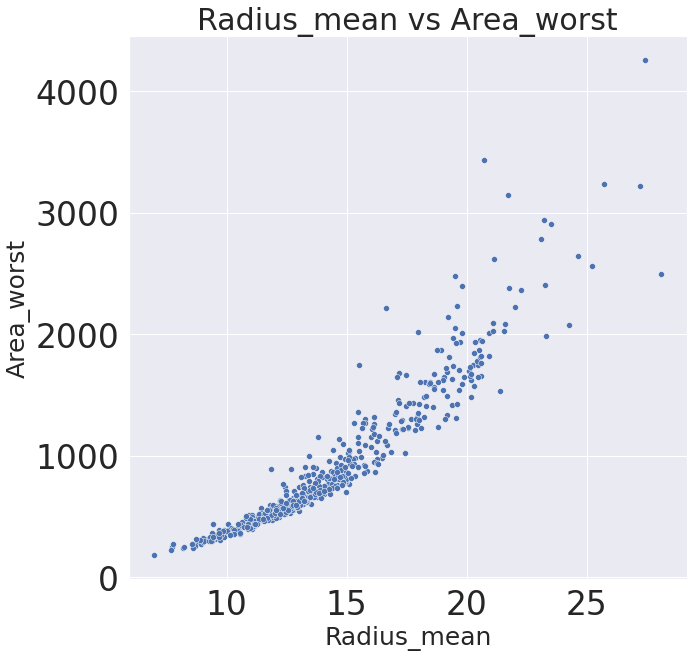

In [ ]:
# Radius_mean vs Area_worst


#scatter plot
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot Radius_mean vs Area_worst
axes = sns.scatterplot(data = Breast_cancer_df, x = "radius_mean", y= "area_worst")

axes.set_title('Radius_mean vs Area_worst', fontsize = 30)

axes.set_xlabel("Radius_mean", fontsize = 25)
axes.set_ylabel("Area_worst", fontsize = 25)


plt.show() 

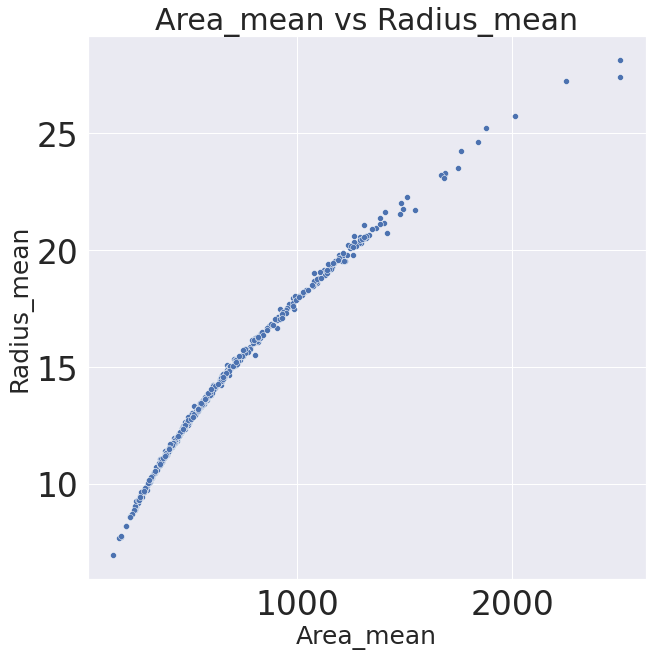

In [ ]:
# Area_mean vs Radius_mean


#scatter plot
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot Area_mean vs Radius_mean
axes = sns.scatterplot(data = Breast_cancer_df, x = "area_mean", y= "radius_mean")

axes.set_title('Area_mean vs Radius_mean', fontsize = 30)

axes.set_xlabel("Area_mean", fontsize = 25)
axes.set_ylabel("Radius_mean", fontsize = 25)


plt.show() 

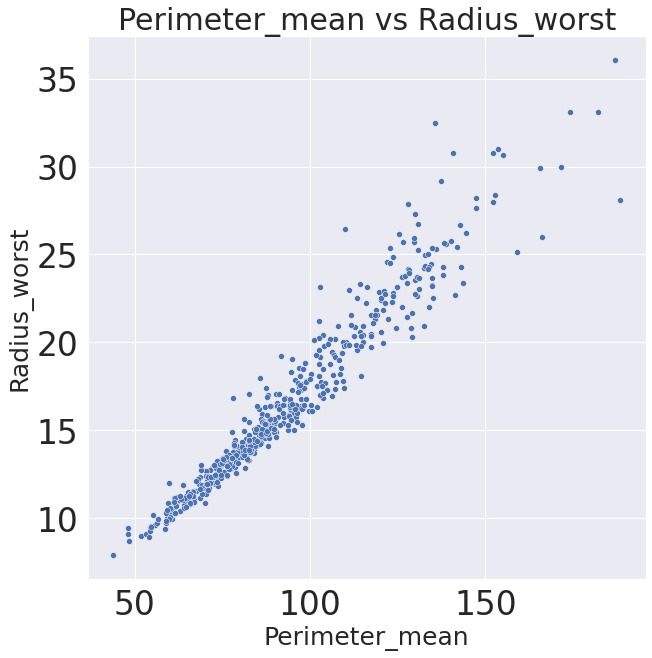

In [ ]:
# Perimeter_mean vs Radius_worst


#scatter plot
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot Perimeter_mean vs Radius_worst
axes = sns.scatterplot(data = Breast_cancer_df, x = "perimeter_mean", y= "radius_worst")

axes.set_title('Perimeter_mean vs Radius_worst', fontsize = 30)

axes.set_xlabel("Perimeter_mean", fontsize = 25)
axes.set_ylabel("Radius_worst", fontsize = 25)


plt.show() 

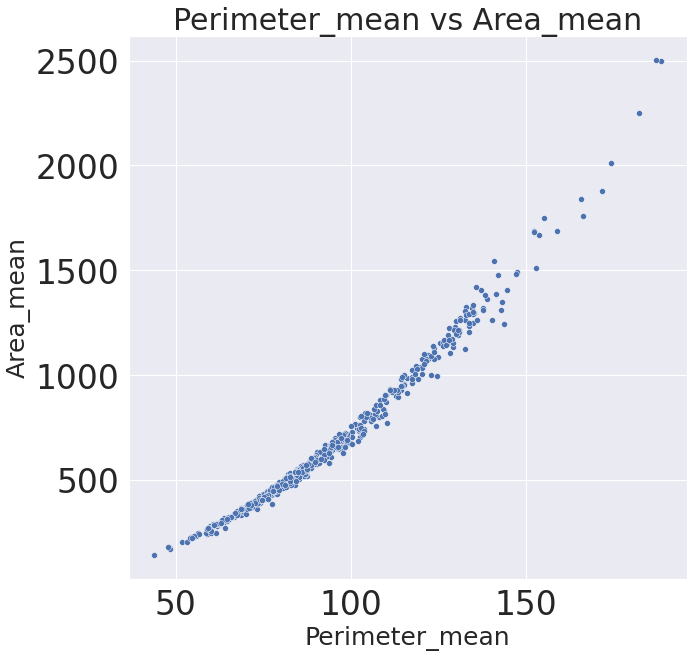

In [ ]:
# Perimeter_mean vs Area_mean


#scatter plot
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot Perimeter_mean vs Area_mean
axes = sns.scatterplot(data = Breast_cancer_df, x = "perimeter_mean", y= "area_mean")

axes.set_title('Perimeter_mean vs Area_mean', fontsize = 30)

axes.set_xlabel("Perimeter_mean", fontsize = 25)
axes.set_ylabel("Area_mean", fontsize = 25)


plt.show() 

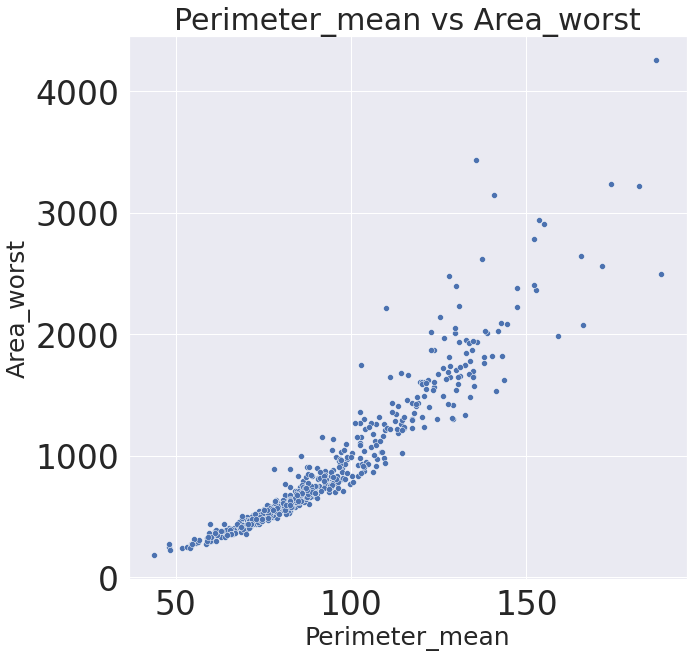

In [ ]:
# Perimeter_mean vs Area_worst


#scatter plot
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot Perimeter_mean vs Area_worst
axes = sns.scatterplot(data = Breast_cancer_df, x = "perimeter_mean", y= "area_worst")

axes.set_title('Perimeter_mean vs Area_worst', fontsize = 30)

axes.set_xlabel("Perimeter_mean", fontsize = 25)
axes.set_ylabel("Area_worst", fontsize = 25)


plt.show() 

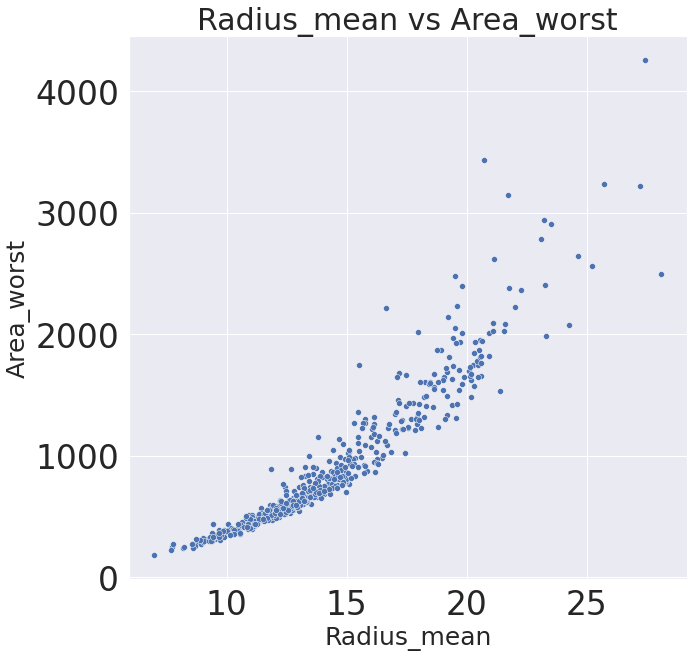

In [ ]:
# Radius_mean vs Area_worst


#scatter plot
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot Radius_mean vs Area_worst
axes = sns.scatterplot(data = Breast_cancer_df, x = "radius_mean", y= "area_worst")

axes.set_title('Radius_mean vs Area_worst', fontsize = 30)

axes.set_xlabel("Radius_mean", fontsize = 25)
axes.set_ylabel("Area_worst", fontsize = 25)


plt.show() 

## **Other Examples:**


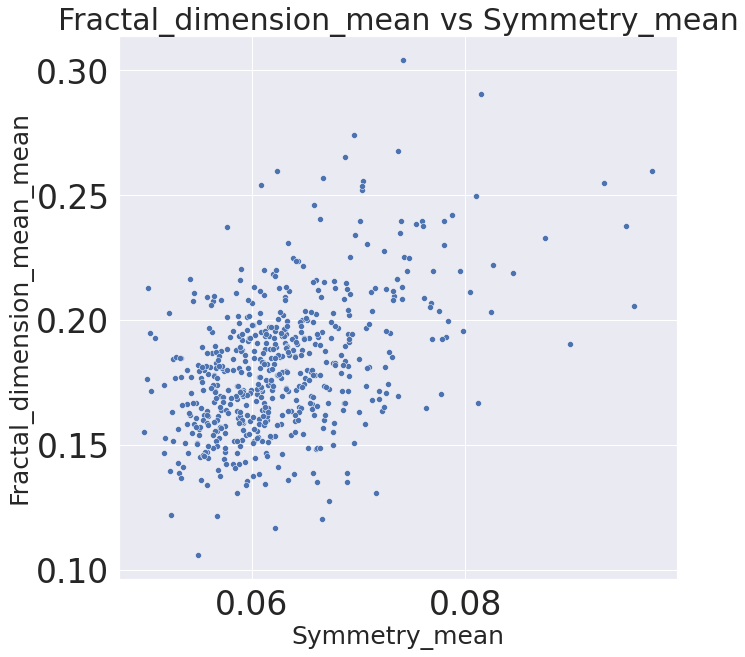

In [14]:
# Fractal_dimension_mean vs Symmetry_mean


#scatter plot
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot Fractal_dimension_mean vs Symmetry_mean
axes = sns.scatterplot(data = Breast_cancer_df, x = "fractal_dimension_mean", y= "symmetry_mean")

axes.set_title('Fractal_dimension_mean vs Symmetry_mean', fontsize = 30)

axes.set_xlabel("Symmetry_mean", fontsize = 25)
axes.set_ylabel("Fractal_dimension_mean_mean", fontsize = 25)


plt.show() 

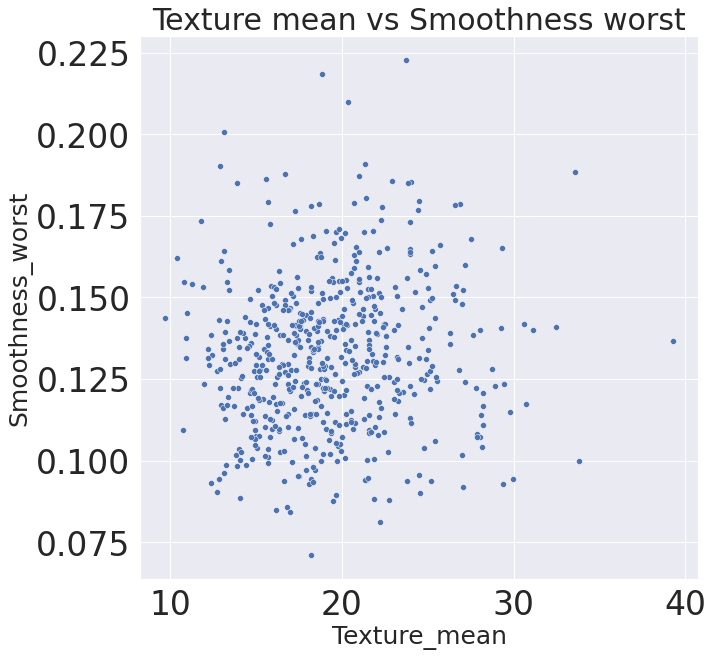

In [16]:
# Texture mean vs Smoothness worst

#scatter plot
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot Texture mean vs Smoothness worst
axes = sns.scatterplot(data = Breast_cancer_df, x = "texture_mean", y= "smoothness_worst")

axes.set_title('Texture mean vs Smoothness worst', fontsize = 30)

axes.set_xlabel("Texture_mean", fontsize = 25)
axes.set_ylabel("Smoothness_worst", fontsize = 25)


plt.show() 

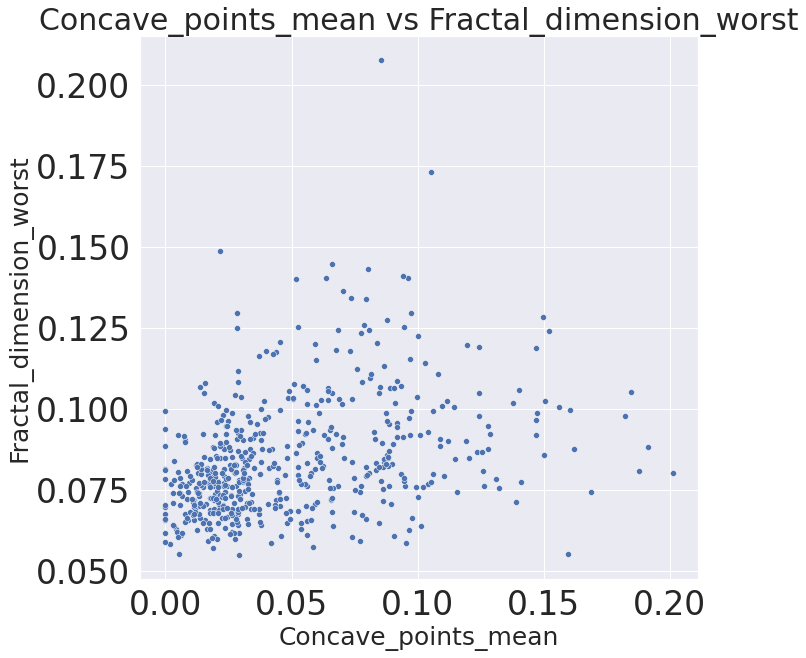

In [19]:
# Concave_points_mean vs Fractal_dimension_worst

#scatter plot
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot Concave_points_mean vs Fractal_dimesion_worst
axes = sns.scatterplot(data = Breast_cancer_df, x = "concave_points_mean", y= "fractal_dimension_worst")

axes.set_title('Concave_points_mean vs Fractal_dimension_worst', fontsize = 30)

axes.set_xlabel("Concave_points_mean", fontsize = 25)
axes.set_ylabel("Fractal_dimension_worst", fontsize = 25)


plt.show() 

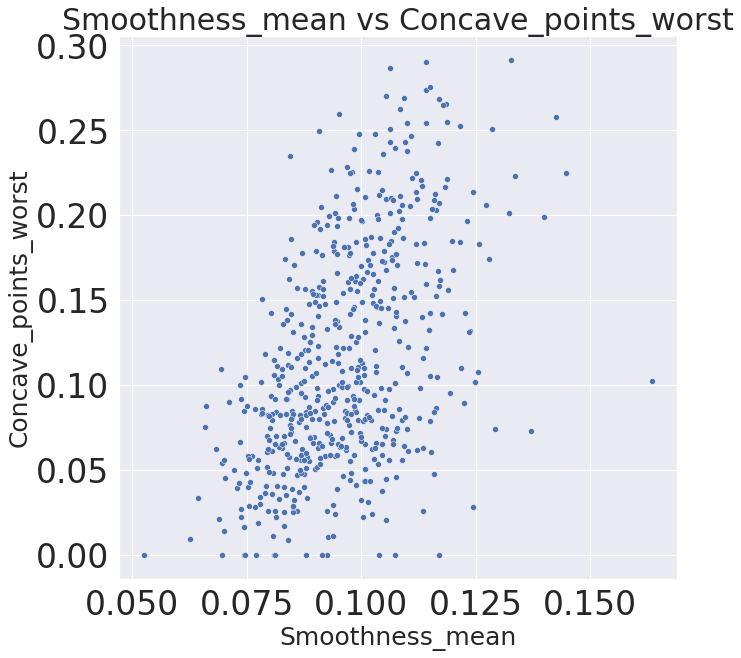

In [20]:
# Smoothness_mean vs Concave_points_worst

#scatter plot
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot Smoothness_mean vs Concave_points_worst
axes = sns.scatterplot(data = Breast_cancer_df, x = "smoothness_mean", y= "concave_points_worst")

axes.set_title('Smoothness_mean vs Concave_points_worst', fontsize = 30)

axes.set_xlabel("Smoothness_mean", fontsize = 25)
axes.set_ylabel("Concave_points_worst", fontsize = 25)


plt.show() 

In [8]:
# Pulling Dependencies for 3D model
!pip install hvplot
!pip install plotly
import pandas as pd
from sklearn.cluster import KMeans
import plotly.express as px
import hvplot.pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# Note: All cell measurement features appear to correlate to each other naturally.
# Area is equal to Perimeter^2
# Area is also raidus^2*pi
# Using the heatmap and 3D models, we will confirm how cell measurements contributes to the accuracy of our model. 

In [10]:
# Plotting other features with area or perimeter as a x value for scale.
# Plotting clusters with three features: testing Concavity_worst and Compactness_worst
fig = px.scatter_3d(
    Breast_cancer_df,
    x="area_mean",
    y="concavity_worst",
    z="compactness_worst",
    color="area_mean",
    symbol="diagnosis", 
    size="area_mean", 
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [ ]:
# Without the Area measurement, the other two values overlap and provide no disticnt pattern. 
# With Area_mean we are able to identidfy that somewhere between 500-700 micro-meters (um) these two features become distinctly sepearted by the cell growth or size.

In [11]:
# Plotting other features with area or perimeter as a x value for scale.
# Plotting clusters with three features: testing symmetry_mean and fractal_dimension_worst
fig = px.scatter_3d(
    Breast_cancer_df,
    x="perimeter_mean",
    y="symmetry_mean",
    z="fractal_dimension_mean",
    color="perimeter_mean",
    symbol="diagnosis", 
    size="perimeter_mean", 
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [ ]:
# Again we see here that even though our heatmap shows some correlation between symmetry mean and fractal dimension mean, without perimeter
# mean to offset the two features, there would be an overlaping cluster with no distinct pattern. 
# -- For this model, cells between 80 um - 85 um in their perimeter_mean create a the distinction between the benign and malignant tumors.
# To conclude our analysis, we will run one more ML model run on both linear regression and logistic regression to see how they perform 
# without any cellular size measurements. 

# Second ML model run; All length size features dropped.

In [ ]:
# Create our Feature
X = Breast_cancer2_df.drop(["diagnosis","id"], axis=1)
X = pd.get_dummies(X)

# Create our Target
y = Breast_cancer2_df["diagnosis"]

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
print(f'Train set lenght: {X_train.count()} records')
print(f'Test set lenght: {X_test.count()} records')

Train set lenght: texture_mean               381
smoothness_mean            381
compactness_mean           381
concavity_mean             381
concave_points_mean        381
symmetry_mean              381
fractal_dimension_mean     381
texture_se                 381
smoothness_se              381
compactness_se             381
concavity_se               381
concave points_se          381
symmetry_se                381
fractal_dimension_se       381
texture_worst              381
smoothness_worst           381
compactness_worst          381
concavity_worst            381
concave_points_worst       381
symmetry_worst             381
fractal_dimension_worst    381
dtype: int64 records
Test set lenght: texture_mean               188
smoothness_mean            188
compactness_mean           188
concavity_mean             188
concave_points_mean        188
symmetry_mean              188
fractal_dimension_mean     188
texture_se                 188
smoothness_se              188
compactness_se

In [ ]:
# Check the Feature values
X.describe()

texture_mean  smoothness_mean  compactness_mean  concavity_mean  \
count    569.000000       569.000000        569.000000      569.000000   
mean      19.289649         0.096360          0.104341        0.088799   
std        4.301036         0.014064          0.052813        0.079720   
min        9.710000         0.052630          0.019380        0.000000   
25%       16.170000         0.086370          0.064920        0.029560   
50%       18.840000         0.095870          0.092630        0.061540   
75%       21.800000         0.105300          0.130400        0.130700   
max       39.280000         0.163400          0.345400        0.426800   

       concave_points_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
count           569.000000     569.000000              569.000000  569.000000   
mean              0.048919       0.181162                0.062798    1.216853   
std               0.038803       0.027414                0.007060    0.551648   
min               0.000000       0.106000                0.049960    0.360200   
25%               0.020310       0.161900                0.057700    0.833900   
50%               0.033500       0.179200                0.061540    1.108000   
75%               0.074000       0.195700                0.066120    1.474000   
max               0.201200       0.304000                0.097440    4.885000   

       smoothness_se  compactness_se  ...  concave points_se  symmetry_se  \
count     569.000000      569.000000  ...         569.000000   569.000000   
mean        0.007041        0.025478  ...           0.011796     0.020542   
std         0.003003        0.017908  ...           0.006170     0.008266   
min         0.001713        0.002252  ...           0.000000     0.007882   
25%         0.005169        0.013080  ...           0.007638     0.015160   
50%         0.006380        0.020450  ...           0.010930     0.018730   
75%         0.008146        0.032450  ...           0.014710     0.023480   
max         0.031130        0.135400  ...           0.052790     0.078950   

       fractal_dimension_se  texture_worst  smoothness_worst  \
count            569.000000     569.000000        569.000000   
mean               0.003795      25.677223          0.132369   
std                0.002646       6.146258          0.022832   
min                0.000895      12.020000          0.071170   
25%                0.002248      21.080000          0.116600   
50%                0.003187      25.410000          0.131300   
75%                0.004558      29.720000          0.146000   
max                0.029840      49.540000          0.222600   

       compactness_worst  concavity_worst  concave_points_worst  \
count         569.000000       569.000000            569.000000   
mean            0.254265         0.272188              0.114606   
std             0.157336         0.208624              0.065732   
min             0.027290         0.000000              0.000000   
25%             0.147200         0.114500              0.064930   
50%             0.211900         0.226700              0.099930   
75%             0.339100         0.382900              0.161400   
max             1.058000         1.252000              0.291000   

       symmetry_worst  fractal_dimension_worst  
count      569.000000               569.000000  
mean         0.290076                 0.083946  
std          0.061867                 0.018061  
min          0.156500                 0.055040  
25%          0.250400                 0.071460  
50%          0.282200                 0.080040  
75%          0.317900                 0.092080  
max          0.663800                 0.207500  

[8 rows x 21 columns]

In [ ]:
# training model our second dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

len(X_train), len(X_test)

(426, 143)

In [ ]:
# Scale the Data
scaled_data = StandardScaler()
X_train = scaled_data.fit_transform(X_train)
X_test = scaled_data.transform(X_test)

# Balance the data since the y values are imblanced
over_samp =  RandomOverSampler(random_state=42)
X_train_res, y_train_res = over_samp.fit_resample(X, y)
X_train_res.shape, y_train_res.shape

((714, 21), (714,))

In [ ]:
# Build Linear Regression Model with all the features
# Create and fit the model
model = LinearRegression()
model.fit(X_test, y_test)

LinearRegression()

In [ ]:
LinearRegressionScore = model.score(X_test, y_test)
print("Accuracy Score for Linear Regression model including all features:",LinearRegressionScore*100,"%")

Accuracy Score for Linear Regression model including all features: 79.25057322144204 %


# Logistical Regression of our Second ML model run

In [ ]:
#logistic regression import
from sklearn.linear_model import LogisticRegression

#logistic regression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [ ]:
#fit training data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [ ]:
#predict values
y_pred = classifier.predict(X_test)

#print results
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(20)

Prediction  Actual
0            1       1
1            2       2
2            2       2
3            1       1
4            1       1
5            2       2
6            2       2
7            1       2
8            2       1
9            1       1
10           1       1
11           2       2
12           1       1
13           1       2
14           1       1
15           2       2
16           1       1
17           1       1
18           1       1
19           2       2

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Classification Report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(cm_df)

Classification Report
              precision    recall  f1-score   support

           1       0.94      0.96      0.95        89
           2       0.92      0.91      0.92        54

    accuracy                           0.94       143
   macro avg       0.93      0.93      0.93       143
weighted avg       0.94      0.94      0.94       143

Confusion Matrix
          Predicted 0  Predicted 1
Actual 0           85            4
Actual 1            5           49


In [ ]:
#accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9370629370629371


# Conclusion:

In [ ]:
# There is clearly other features in our dataset that provide a clear definition of begnin and malignant cellular distinction. While our logistic model showed the greatest drop in performance after removing all the features about cell size, the drop was only by about 4 points in accuracy. 
# At this time we can accept that our data and models appear to be working well to identify malignant cells from benign. 